In [92]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## !! CHANGE ME !! ##
os.chdir('C:\\ali\\packages\\s2p-lbm')

In [3]:
from suite2p.io import lbm as lbmio
from suite2p.suite3d.job import Job
from suite2p.suite3d import extension as ext

from suite2p.suite3d import iter_step
from utils import tiff_utils as tfu
from dask import array as darr

## Load previously registered files

In [4]:
## !! Change Me !! ##
analysis_dir = 'Y:\\analysis\\example'

In [5]:
job = Job(analysis_dir, 'test_experiment_001', create=False)

Job directory Y:\analysis\example\s3d-test_experiment_001 already exists
Loading job directory for test_experiment_001 in Y:\analysis\example
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Found and loaded params from Y:\analysis\example\s3d-test_experiment_001\params.npy
      Updated params file: Y:\analysis\example\s3d-test_experiment_001\params.npy


In [6]:
summary = job.load_summary()

## Calculate correlation map

In [436]:
job.params['t_batch_size'] = 1000 # how many frames to process in each batch
                                 # the memory requirement is about 8x the size of the array
                                 # so maybe do 1/10 of your RAM to be safe
        
job.params['temporal_hpf'] = 100 # width of the temporal rolling average filter 

job.params['npil_hpf_xy'] = 8    # width in pixels of the neuropil filter, this works for 3.5 um/pix resolution
job.params['npil_hpf_z'] = 2     # same, in z

job.params['unif_filter_xy'] = 3 # roughly, minimum width in pixels of a cell. this works for 3.5 um/pix resolution
job.params['unif_filter_z'] = 3  # same, in z

# time points where value of the normalized movie is below this threshold will not be used for the corr map
# increasing will increase the difference between the bright and dim spots of the corrmap, effectively making 
# the background darker. But if you increase too much, you will start losing ROIs and everything will become black.
# It always works fine if you leave it at 0, increasing it might improve things or make them worse
job.params['intensity_thresh'] = 0

job.params['n_proc_corr'] = 12  # number of processors to use for correlation map calculation
job.params['mproc_batchsize'] = 100 # for the filtering step, size (in frames) of the batch each process will get
job.params['fix_vmap_edges'] = True # fixes the magnitude of the edge planes (filtering makes them artificially different)

In [447]:
mov3d = job.get_registered_movie('registered_fused_data', 'fused')
nz,nt,ny,nx = mov3d.shape

In [448]:
# to test out parameters before running on the whole thing, you can do this (which won't save the vmap):
# vmap_test = job.calculate_corr_map(mov3d[0:5, :1000, 600:800, 200:400])

In [449]:
# once you have optimized your parameters, you can run on the full FOV and save
vmap = job.calculate_corr_map(mov3d[:,:])

      Updated params file: Y:\analysis\example\s3d-test_experiment_001\params.npy
   Created files and dirs for 3 batches
0
      Running batch 1
      Loaded and swapped from dask, idx 0 to 1000
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\analysis\example\s3d-test_experiment_001\iters\batch0000
      Running batch 2
      Loaded and swapped from dask, idx 1000 to 2000
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\analysis\example\s3d-test_experiment_001\iters\batch0001
      Running batch 3
      Loaded and swapped from dask, idx 2000 to 3000
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\analysis\example\s3d-test_experiment_001\iters\batch0002


In [475]:
vmap = job.load_iter_results(-1)['vmap']

   Loading from Y:\analysis\example\s3d-test_experiment_001\iters\batch0000


(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x12cb9002f10>)

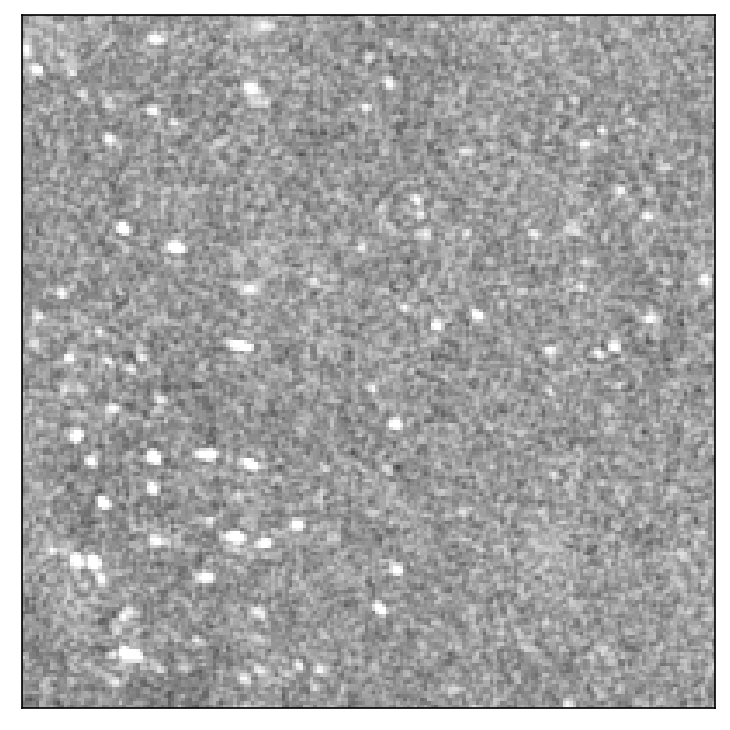

In [483]:
# only 1000 frames
tfu.show_tif(vmap[2,600:800, 200:400],vminmax=(3,4.5))

## Cell detection

In [488]:
# this is the minimum value of a peak in the correlation map for it to count as an ROI. Reduce to find more 
# ROIs, increase to find less ROIs (but higher percentage of real cells, probably)
job.params['peak_thresh'] = 4

# these two params select the "active frames" that are used to decide whether candidate pixels are 
# active at the same time as the seed ROI
# if they are too high, the cell extension process will be noisier and non-cell pixels are likelier 
# to be included in the main ROI, so if you see a lot of cells with non-smooth edges and pixels sticking out,
# try to decrease these two values
job.params['activity_thresh'] = 1.3
job.params['percentile'] = 98


job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch

job.params['detection_timebin'] = 2  # downsample (time-bin) movie by this factor for detection
                                     # to save RAM and accelerate. Should be roughly ~1 frame / action potential,
                                     # I downsample from 2.8 Hz to 1.4 Hz for my G6s recordings
                                     # also speeds things up quite a bit! 
        
# better to not mess with these
job.params['extend_thresh'] = 0.2    # When extending an ROI, the threshold of shared activty above which a candidate pixel will be added to ROI
job.params['roi_ext_iterations'] = 2 # how many times to recompute timecourse and re-extend  each ROI. lower: smaller ROIs, higher: bigger ROIs.

In [490]:
%%time
stats = job.detect_cells_from_patch(patch_idx = 0, zs = (0,5), ys = (600,800), xs = (200,400))

      Updated params file: Y:\analysis\example\s3d-test_experiment_001\params.npy
   Loading from Y:\analysis\example\s3d-test_experiment_001\iters\batch0000


C:\Users\ali\anaconda3\envs\s2p-lbm\lib\site-packages\IPython\core\interactiveshell.py:3433: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)


   Saving cell stats and info to Y:\analysis\example\s3d-test_experiment_001\detection\patch-0000
   Starting extraction with peak_thresh: 4.000 and Th2: 1.500
      Cell 0 at with peak 7.136, activity_thresh 1.500, max 4.699
         163/1500 active frames
         303/1500 active frames
      Added cell 1 at 04, 128, 038 with peak: 7.136 and 33 pixels
      Cell 1 at with peak 6.225, activity_thresh 1.145, max 3.288
         75/1500 active frames
         121/1500 active frames
      Added cell 2 at 00, 095, 060 with peak: 6.225 and 43 pixels
      Cell 2 at with peak 6.022, activity_thresh 1.252, max 4.615
         75/1500 active frames
         88/1500 active frames
      Added cell 3 at 00, 100, 025 with peak: 6.022 and 17 pixels
      Cell 3 at with peak 5.954, activity_thresh 1.231, max 7.778
         75/1500 active frames
         92/1500 active frames
      Added cell 4 at 02, 184, 030 with peak: 5.954 and 39 pixels
      Cell 4 at with peak 5.836, activity_thresh 1.016, max 4

         84/1500 active frames
      Added cell 45 at 02, 171, 103 with peak: 5.047 and 22 pixels
      Cell 45 at with peak 5.045, activity_thresh 1.015, max 2.530
         75/1500 active frames
         88/1500 active frames
      Added cell 46 at 00, 145, 052 with peak: 5.045 and 27 pixels
      Cell 46 at with peak 5.023, activity_thresh 1.256, max 6.831
         75/1500 active frames
         83/1500 active frames
      Added cell 47 at 00, 132, 044 with peak: 5.023 and 18 pixels
      Cell 47 at with peak 5.013, activity_thresh 1.234, max 3.570
         75/1500 active frames
         76/1500 active frames
      Added cell 48 at 04, 098, 012 with peak: 5.013 and 14 pixels
      Cell 48 at with peak 5.007, activity_thresh 1.052, max 2.326
         75/1500 active frames
         83/1500 active frames
      Added cell 49 at 01, 199, 088 with peak: 5.007 and 7 pixels
      Cell 49 at with peak 4.998, activity_thresh 1.061, max 2.367
         75/1500 active frames
         78/1500 acti

      Added cell 87 at 01, 061, 158 with peak: 4.708 and 10 pixels
      Cell 87 at with peak 4.707, activity_thresh 1.088, max 2.742
         75/1500 active frames
         82/1500 active frames
      Added cell 88 at 01, 141, 023 with peak: 4.707 and 12 pixels
      Cell 88 at with peak 4.705, activity_thresh 1.113, max 2.773
         75/1500 active frames
         82/1500 active frames
      Added cell 89 at 03, 140, 022 with peak: 4.705 and 15 pixels
      Cell 89 at with peak 4.700, activity_thresh 1.037, max 3.070
         75/1500 active frames
         75/1500 active frames
      Added cell 90 at 04, 129, 019 with peak: 4.700 and 12 pixels
      Cell 90 at with peak 4.697, activity_thresh 1.062, max 2.172
         75/1500 active frames
         81/1500 active frames
      Added cell 91 at 02, 096, 065 with peak: 4.697 and 11 pixels
      Cell 91 at with peak 4.692, activity_thresh 1.157, max 2.598
         75/1500 active frames
         82/1500 active frames
      Added cell 92 

      Added cell 131 at 02, 097, 166 with peak: 4.542 and 14 pixels
      Cell 131 at with peak 4.538, activity_thresh 1.107, max 2.563
         75/1500 active frames
         80/1500 active frames
      Added cell 132 at 03, 184, 167 with peak: 4.538 and 12 pixels
      Cell 132 at with peak 4.536, activity_thresh 1.019, max 2.696
         75/1500 active frames
         87/1500 active frames
      Added cell 133 at 02, 146, 080 with peak: 4.536 and 8 pixels
      Cell 133 at with peak 4.528, activity_thresh 1.166, max 3.390
         75/1500 active frames
         74/1500 active frames
      Added cell 134 at 02, 058, 180 with peak: 4.528 and 11 pixels
      Cell 134 at with peak 4.528, activity_thresh 1.090, max 3.307
         75/1500 active frames
         72/1500 active frames
      Added cell 135 at 04, 184, 031 with peak: 4.528 and 11 pixels
      Cell 135 at with peak 4.526, activity_thresh 1.074, max 2.972
         75/1500 active frames
         78/1500 active frames
      Added

         92/1500 active frames
      Added cell 175 at 00, 125, 057 with peak: 4.433 and 13 pixels
      Cell 175 at with peak 4.431, activity_thresh 1.114, max 2.652
         75/1500 active frames
         103/1500 active frames
      Added cell 176 at 00, 027, 155 with peak: 4.431 and 15 pixels
      Cell 176 at with peak 4.429, activity_thresh 1.053, max 3.788
         75/1500 active frames
         89/1500 active frames
      Added cell 177 at 04, 026, 070 with peak: 4.429 and 14 pixels
      Cell 177 at with peak 4.429, activity_thresh 1.050, max 4.202
         75/1500 active frames
         82/1500 active frames
      Added cell 178 at 02, 022, 065 with peak: 4.429 and 10 pixels
      Cell 178 at with peak 4.429, activity_thresh 1.124, max 2.517
         75/1500 active frames
         76/1500 active frames
      Added cell 179 at 04, 108, 016 with peak: 4.429 and 9 pixels
      Cell 179 at with peak 4.429, activity_thresh 1.031, max 1.991
         75/1500 active frames
         7

      Added cell 218 at 02, 020, 064 with peak: 4.379 and 10 pixels
      Cell 218 at with peak 4.379, activity_thresh 1.083, max 4.406
         75/1500 active frames
         76/1500 active frames
      Added cell 219 at 01, 189, 068 with peak: 4.379 and 14 pixels
      Cell 219 at with peak 4.379, activity_thresh 1.000, max 2.107
         75/1500 active frames
         85/1500 active frames
      Added cell 220 at 01, 186, 032 with peak: 4.379 and 8 pixels
      Cell 220 at with peak 4.378, activity_thresh 1.169, max 5.464
         75/1500 active frames
         78/1500 active frames
      Added cell 221 at 04, 069, 159 with peak: 4.378 and 10 pixels
      Cell 221 at with peak 4.377, activity_thresh 1.107, max 3.143
         75/1500 active frames
         91/1500 active frames
      Added cell 222 at 01, 076, 158 with peak: 4.377 and 14 pixels
      Cell 222 at with peak 4.373, activity_thresh 1.106, max 2.757
         75/1500 active frames
         86/1500 active frames
      Added

      Cell 262 at with peak 4.316, activity_thresh 1.084, max 2.479
         75/1500 active frames
         85/1500 active frames
      Added cell 263 at 03, 057, 180 with peak: 4.316 and 9 pixels
      Cell 263 at with peak 4.315, activity_thresh 0.992, max 2.233
         75/1500 active frames
         81/1500 active frames
      Added cell 264 at 00, 183, 030 with peak: 4.315 and 8 pixels
      Cell 264 at with peak 4.310, activity_thresh 1.039, max 2.612
         75/1500 active frames
         87/1500 active frames
      Added cell 265 at 01, 139, 022 with peak: 4.310 and 10 pixels
      Cell 265 at with peak 4.309, activity_thresh 1.127, max 2.890
         75/1500 active frames
         81/1500 active frames
      Added cell 266 at 03, 163, 011 with peak: 4.309 and 13 pixels
      Cell 266 at with peak 4.308, activity_thresh 1.054, max 2.526
         75/1500 active frames
         89/1500 active frames
      Added cell 267 at 02, 159, 016 with peak: 4.308 and 9 pixels
      Cell 26

      Added cell 306 at 02, 128, 053 with peak: 4.276 and 9 pixels
      Cell 306 at with peak 4.275, activity_thresh 1.025, max 2.584
         75/1500 active frames
         95/1500 active frames
      Added cell 307 at 03, 185, 033 with peak: 4.275 and 9 pixels
      Cell 307 at with peak 4.274, activity_thresh 1.077, max 2.569
         75/1500 active frames
         82/1500 active frames
      Added cell 308 at 02, 003, 071 with peak: 4.274 and 10 pixels
      Cell 308 at with peak 4.274, activity_thresh 1.075, max 2.840
         75/1500 active frames
         89/1500 active frames
      Added cell 309 at 03, 131, 105 with peak: 4.274 and 15 pixels
      Cell 309 at with peak 4.274, activity_thresh 1.089, max 2.955
         75/1500 active frames
         81/1500 active frames
      Added cell 310 at 01, 144, 101 with peak: 4.274 and 15 pixels
      Cell 310 at with peak 4.273, activity_thresh 1.120, max 3.257
         75/1500 active frames
         88/1500 active frames
      Added 

      Added cell 351 at 03, 130, 088 with peak: 4.229 and 12 pixels
      Cell 351 at with peak 4.229, activity_thresh 1.041, max 3.195
         75/1500 active frames
         89/1500 active frames
      Added cell 352 at 03, 158, 022 with peak: 4.229 and 10 pixels
      Cell 352 at with peak 4.227, activity_thresh 0.932, max 2.099
         75/1500 active frames
         84/1500 active frames
      Added cell 353 at 00, 156, 190 with peak: 4.227 and 8 pixels
      Cell 353 at with peak 4.227, activity_thresh 1.227, max 3.247
         75/1500 active frames
         74/1500 active frames
      Added cell 354 at 03, 024, 159 with peak: 4.227 and 10 pixels
      Cell 354 at with peak 4.227, activity_thresh 0.927, max 3.019
         75/1500 active frames
         93/1500 active frames
      Added cell 355 at 02, 137, 036 with peak: 4.227 and 9 pixels
      Cell 355 at with peak 4.226, activity_thresh 1.138, max 2.322
         75/1500 active frames
         82/1500 active frames
      Added 

         86/1500 active frames
      Added cell 395 at 03, 156, 050 with peak: 4.203 and 13 pixels
      Cell 395 at with peak 4.201, activity_thresh 1.144, max 2.299
         75/1500 active frames
         76/1500 active frames
      Added cell 396 at 04, 028, 131 with peak: 4.201 and 10 pixels
      Cell 396 at with peak 4.201, activity_thresh 1.048, max 3.659
         75/1500 active frames
         81/1500 active frames
      Added cell 397 at 02, 170, 101 with peak: 4.201 and 10 pixels
      Cell 397 at with peak 4.201, activity_thresh 0.905, max 3.489
         75/1500 active frames
         95/1500 active frames
      Added cell 398 at 00, 101, 024 with peak: 4.201 and 8 pixels
      Cell 398 at with peak 4.201, activity_thresh 1.114, max 2.653
         75/1500 active frames
         78/1500 active frames
      Added cell 399 at 03, 007, 151 with peak: 4.201 and 10 pixels
      Cell 399 at with peak 4.200, activity_thresh 1.239, max 3.345
         75/1500 active frames
         83

         78/1500 active frames
      Added cell 439 at 02, 149, 196 with peak: 4.180 and 9 pixels
      Cell 439 at with peak 4.180, activity_thresh 1.122, max 2.625
         75/1500 active frames
         75/1500 active frames
      Added cell 440 at 04, 147, 157 with peak: 4.180 and 9 pixels
      Cell 440 at with peak 4.179, activity_thresh 0.998, max 2.553
         75/1500 active frames
         84/1500 active frames
      Added cell 441 at 01, 158, 017 with peak: 4.179 and 8 pixels
      Cell 441 at with peak 4.178, activity_thresh 1.112, max 2.677
         75/1500 active frames
         77/1500 active frames
      Added cell 442 at 02, 026, 024 with peak: 4.178 and 10 pixels
      Cell 442 at with peak 4.178, activity_thresh 1.035, max 4.318
         75/1500 active frames
         81/1500 active frames
      Added cell 443 at 02, 044, 186 with peak: 4.178 and 11 pixels
      Cell 443 at with peak 4.178, activity_thresh 1.028, max 1.830
         75/1500 active frames
         84/1

      Added cell 484 at 04, 127, 056 with peak: 4.163 and 9 pixels
      Cell 484 at with peak 4.163, activity_thresh 1.053, max 2.263
         75/1500 active frames
         74/1500 active frames
      Added cell 485 at 02, 183, 167 with peak: 4.163 and 9 pixels
      Cell 485 at with peak 4.162, activity_thresh 1.143, max 2.803
         75/1500 active frames
         83/1500 active frames
      Added cell 486 at 04, 116, 002 with peak: 4.162 and 9 pixels
      Cell 486 at with peak 4.162, activity_thresh 1.091, max 2.902
         75/1500 active frames
         82/1500 active frames
      Added cell 487 at 02, 063, 114 with peak: 4.162 and 9 pixels
      Cell 487 at with peak 4.162, activity_thresh 1.066, max 2.054
         75/1500 active frames
         82/1500 active frames
      Added cell 488 at 03, 158, 061 with peak: 4.162 and 9 pixels
      Cell 488 at with peak 4.162, activity_thresh 1.008, max 2.563
         75/1500 active frames
         80/1500 active frames
      Added cel

      Added cell 525 at 03, 154, 061 with peak: 4.151 and 9 pixels
      Cell 525 at with peak 4.150, activity_thresh 1.056, max 1.975
         75/1500 active frames
         94/1500 active frames
      Added cell 526 at 03, 021, 065 with peak: 4.150 and 10 pixels
      Cell 526 at with peak 4.150, activity_thresh 1.000, max 2.331
         75/1500 active frames
         92/1500 active frames
      Added cell 527 at 00, 159, 089 with peak: 4.150 and 10 pixels
      Cell 527 at with peak 4.150, activity_thresh 1.200, max 3.428
         75/1500 active frames
         83/1500 active frames
      Added cell 528 at 00, 034, 025 with peak: 4.150 and 11 pixels
      Cell 528 at with peak 4.150, activity_thresh 1.207, max 3.410
         75/1500 active frames
         83/1500 active frames
      Added cell 529 at 04, 035, 152 with peak: 4.150 and 9 pixels
      Cell 529 at with peak 4.150, activity_thresh 1.125, max 2.084
         75/1500 active frames
         82/1500 active frames
      Added 

         78/1500 active frames
      Added cell 568 at 04, 156, 048 with peak: 4.136 and 10 pixels
      Cell 568 at with peak 4.136, activity_thresh 0.948, max 1.991
         75/1500 active frames
         95/1500 active frames
      Added cell 569 at 00, 077, 160 with peak: 4.136 and 8 pixels
      Cell 569 at with peak 4.136, activity_thresh 0.954, max 2.477
         75/1500 active frames
         89/1500 active frames
      Added cell 570 at 02, 129, 063 with peak: 4.136 and 12 pixels
      Cell 570 at with peak 4.135, activity_thresh 1.102, max 2.640
         75/1500 active frames
         81/1500 active frames
      Added cell 571 at 02, 023, 018 with peak: 4.135 and 10 pixels
      Cell 571 at with peak 4.135, activity_thresh 1.233, max 2.845
         75/1500 active frames
         78/1500 active frames
      Added cell 572 at 01, 106, 172 with peak: 4.135 and 9 pixels
      Cell 572 at with peak 4.135, activity_thresh 1.100, max 2.653
         75/1500 active frames
         81/

      Added cell 613 at 02, 007, 048 with peak: 4.125 and 10 pixels
      Cell 613 at with peak 4.125, activity_thresh 1.079, max 2.030
         75/1500 active frames
         76/1500 active frames
      Added cell 614 at 03, 146, 155 with peak: 4.125 and 9 pixels
      Cell 614 at with peak 4.124, activity_thresh 1.050, max 3.124
         75/1500 active frames
         78/1500 active frames
      Added cell 615 at 00, 144, 101 with peak: 4.124 and 9 pixels
      Cell 615 at with peak 4.124, activity_thresh 1.110, max 2.707
         75/1500 active frames
         80/1500 active frames
      Added cell 616 at 03, 004, 195 with peak: 4.124 and 8 pixels
      Cell 616 at with peak 4.124, activity_thresh 1.014, max 2.740
         75/1500 active frames
         99/1500 active frames
      Added cell 617 at 01, 026, 097 with peak: 4.124 and 10 pixels
      Cell 617 at with peak 4.123, activity_thresh 1.131, max 3.483
         75/1500 active frames
         77/1500 active frames
      Added c

      Added cell 655 at 02, 079, 144 with peak: 4.115 and 10 pixels
      Cell 655 at with peak 4.115, activity_thresh 1.131, max 3.277
         75/1500 active frames
         78/1500 active frames
      Added cell 656 at 03, 098, 082 with peak: 4.115 and 9 pixels
      Cell 656 at with peak 4.115, activity_thresh 1.113, max 2.544
         75/1500 active frames
         80/1500 active frames
      Added cell 657 at 04, 122, 111 with peak: 4.115 and 9 pixels
      Cell 657 at with peak 4.115, activity_thresh 1.093, max 2.476
         75/1500 active frames
         72/1500 active frames
      Added cell 658 at 04, 050, 173 with peak: 4.115 and 13 pixels
      Cell 658 at with peak 4.115, activity_thresh 1.119, max 3.386
         75/1500 active frames
         87/1500 active frames
      Added cell 659 at 01, 154, 189 with peak: 4.115 and 11 pixels
      Cell 659 at with peak 4.115, activity_thresh 1.133, max 2.321
         75/1500 active frames
         87/1500 active frames
      Added 

         87/1500 active frames
      Added cell 698 at 01, 015, 005 with peak: 4.109 and 11 pixels
      Cell 698 at with peak 4.109, activity_thresh 1.042, max 2.552
         75/1500 active frames
         85/1500 active frames
      Added cell 699 at 03, 121, 015 with peak: 4.109 and 11 pixels
      Cell 699 at with peak 4.109, activity_thresh 1.120, max 3.129
         75/1500 active frames
         82/1500 active frames
      Added cell 700 at 03, 007, 008 with peak: 4.109 and 9 pixels
      Cell 700 at with peak 4.108, activity_thresh 1.076, max 2.047
         75/1500 active frames
         84/1500 active frames
      Added cell 701 at 03, 031, 077 with peak: 4.108 and 10 pixels
      Cell 701 at with peak 4.108, activity_thresh 1.130, max 2.254
         75/1500 active frames
         86/1500 active frames
      Added cell 702 at 02, 049, 161 with peak: 4.108 and 11 pixels
      Cell 702 at with peak 4.108, activity_thresh 0.984, max 2.180
         75/1500 active frames
         87

      Added cell 740 at 02, 152, 194 with peak: 4.101 and 10 pixels
      Cell 740 at with peak 4.100, activity_thresh 1.156, max 1.916
         75/1500 active frames
         73/1500 active frames
      Added cell 741 at 02, 132, 160 with peak: 4.100 and 9 pixels
      Cell 741 at with peak 4.100, activity_thresh 1.069, max 2.199
         75/1500 active frames
         80/1500 active frames
      Added cell 742 at 03, 023, 065 with peak: 4.100 and 10 pixels
      Cell 742 at with peak 4.100, activity_thresh 0.956, max 1.760
         75/1500 active frames
         83/1500 active frames
      Added cell 743 at 00, 152, 060 with peak: 4.100 and 9 pixels
      Cell 743 at with peak 4.100, activity_thresh 1.039, max 2.342
         75/1500 active frames
         83/1500 active frames
      Added cell 744 at 03, 153, 007 with peak: 4.100 and 10 pixels
      Cell 744 at with peak 4.100, activity_thresh 1.142, max 2.407
         75/1500 active frames
         82/1500 active frames
      Added 

      Added cell 783 at 04, 093, 082 with peak: 4.095 and 12 pixels
      Cell 783 at with peak 4.095, activity_thresh 1.039, max 2.101
         75/1500 active frames
         86/1500 active frames
      Added cell 784 at 01, 156, 019 with peak: 4.095 and 11 pixels
      Cell 784 at with peak 4.095, activity_thresh 1.182, max 2.817
         75/1500 active frames
         88/1500 active frames
      Added cell 785 at 04, 170, 155 with peak: 4.095 and 10 pixels
      Cell 785 at with peak 4.094, activity_thresh 1.052, max 2.410
         75/1500 active frames
         81/1500 active frames
      Added cell 786 at 02, 178, 138 with peak: 4.094 and 10 pixels
      Cell 786 at with peak 4.094, activity_thresh 1.083, max 2.626
         75/1500 active frames
         76/1500 active frames
      Added cell 787 at 03, 039, 073 with peak: 4.094 and 9 pixels
      Cell 787 at with peak 4.094, activity_thresh 1.026, max 2.729
         75/1500 active frames
         79/1500 active frames
      Added

      Cell 825 at with peak 4.090, activity_thresh 1.090, max 3.112
         75/1500 active frames
         78/1500 active frames
      Added cell 826 at 04, 099, 015 with peak: 4.090 and 9 pixels
      Cell 826 at with peak 4.089, activity_thresh 1.098, max 2.614
         75/1500 active frames
         84/1500 active frames
      Added cell 827 at 03, 059, 059 with peak: 4.089 and 9 pixels
      Cell 827 at with peak 4.089, activity_thresh 1.061, max 2.650
         75/1500 active frames
         80/1500 active frames
      Added cell 828 at 01, 053, 114 with peak: 4.089 and 9 pixels
      Cell 828 at with peak 4.089, activity_thresh 1.023, max 2.143
         75/1500 active frames
         92/1500 active frames
      Added cell 829 at 04, 161, 053 with peak: 4.089 and 9 pixels
      Cell 829 at with peak 4.089, activity_thresh 1.086, max 2.243
         75/1500 active frames
         80/1500 active frames
      Added cell 830 at 03, 002, 188 with peak: 4.089 and 9 pixels
      Cell 830 

      Added cell 867 at 00, 001, 010 with peak: 4.085 and 10 pixels
      Cell 867 at with peak 4.085, activity_thresh 1.117, max 2.415
         75/1500 active frames
         78/1500 active frames
      Added cell 868 at 04, 180, 175 with peak: 4.085 and 10 pixels
      Cell 868 at with peak 4.084, activity_thresh 1.090, max 2.098
         75/1500 active frames
         85/1500 active frames
      Added cell 869 at 04, 101, 194 with peak: 4.084 and 12 pixels
      Cell 869 at with peak 4.084, activity_thresh 1.094, max 2.898
         75/1500 active frames
         84/1500 active frames
      Added cell 870 at 01, 120, 123 with peak: 4.084 and 10 pixels
      Cell 870 at with peak 4.084, activity_thresh 1.085, max 2.649
         75/1500 active frames
         85/1500 active frames
      Added cell 871 at 03, 115, 192 with peak: 4.084 and 10 pixels
      Cell 871 at with peak 4.084, activity_thresh 1.097, max 2.413
         75/1500 active frames
         81/1500 active frames
      Adde

      Added cell 909 at 01, 148, 084 with peak: 4.079 and 10 pixels
      Cell 909 at with peak 4.079, activity_thresh 0.991, max 2.847
         75/1500 active frames
         79/1500 active frames
      Added cell 910 at 02, 140, 086 with peak: 4.079 and 11 pixels
      Cell 910 at with peak 4.079, activity_thresh 1.043, max 2.323
         75/1500 active frames
         83/1500 active frames
      Added cell 911 at 03, 077, 065 with peak: 4.079 and 10 pixels
      Cell 911 at with peak 4.079, activity_thresh 1.034, max 3.125
         75/1500 active frames
         78/1500 active frames
      Added cell 912 at 01, 097, 133 with peak: 4.079 and 11 pixels
      Cell 912 at with peak 4.079, activity_thresh 1.186, max 2.483
         75/1500 active frames
         82/1500 active frames
      Added cell 913 at 04, 165, 158 with peak: 4.079 and 9 pixels
      Cell 913 at with peak 4.079, activity_thresh 1.084, max 2.597
         75/1500 active frames
         86/1500 active frames
      Added

      Added cell 951 at 03, 151, 039 with peak: 4.075 and 8 pixels
      Cell 951 at with peak 4.075, activity_thresh 1.092, max 2.654
         75/1500 active frames
         77/1500 active frames
      Added cell 952 at 02, 148, 032 with peak: 4.075 and 11 pixels
      Cell 952 at with peak 4.074, activity_thresh 1.107, max 3.118
         75/1500 active frames
         72/1500 active frames
      Added cell 953 at 02, 016, 081 with peak: 4.074 and 11 pixels
      Cell 953 at with peak 4.074, activity_thresh 1.012, max 2.328
         75/1500 active frames
         78/1500 active frames
      Added cell 954 at 03, 157, 179 with peak: 4.074 and 10 pixels
      Cell 954 at with peak 4.074, activity_thresh 1.111, max 2.759
         75/1500 active frames
         78/1500 active frames
      Added cell 955 at 03, 122, 110 with peak: 4.074 and 10 pixels
      Cell 955 at with peak 4.074, activity_thresh 1.121, max 2.147
         75/1500 active frames
         80/1500 active frames
      Added

         78/1500 active frames
      Added cell 993 at 03, 165, 158 with peak: 4.071 and 9 pixels
      Cell 993 at with peak 4.071, activity_thresh 0.982, max 2.592
         75/1500 active frames
         82/1500 active frames
      Added cell 994 at 03, 097, 012 with peak: 4.071 and 9 pixels
      Cell 994 at with peak 4.071, activity_thresh 0.996, max 1.998
         75/1500 active frames
         87/1500 active frames
      Added cell 995 at 02, 111, 041 with peak: 4.071 and 8 pixels
      Cell 995 at with peak 4.071, activity_thresh 1.053, max 2.378
         75/1500 active frames
         81/1500 active frames
      Added cell 996 at 03, 030, 107 with peak: 4.071 and 10 pixels
      Cell 996 at with peak 4.071, activity_thresh 1.116, max 2.250
         75/1500 active frames
         80/1500 active frames
      Added cell 997 at 03, 038, 060 with peak: 4.071 and 11 pixels
      Cell 997 at with peak 4.071, activity_thresh 1.140, max 3.244
         75/1500 active frames
         84/1

         94/1500 active frames
      Added cell 1036 at 02, 133, 074 with peak: 4.066 and 9 pixels
      Cell 1036 at with peak 4.066, activity_thresh 1.058, max 2.330
         75/1500 active frames
         85/1500 active frames
      Added cell 1037 at 03, 083, 024 with peak: 4.066 and 10 pixels
      Cell 1037 at with peak 4.066, activity_thresh 1.165, max 2.052
         75/1500 active frames
         85/1500 active frames
      Added cell 1038 at 04, 073, 159 with peak: 4.066 and 10 pixels
      Cell 1038 at with peak 4.066, activity_thresh 1.094, max 2.315
         75/1500 active frames
         78/1500 active frames
      Added cell 1039 at 04, 026, 127 with peak: 4.066 and 10 pixels
      Cell 1039 at with peak 4.066, activity_thresh 1.141, max 2.975
         75/1500 active frames
         76/1500 active frames
      Added cell 1040 at 01, 088, 121 with peak: 4.066 and 10 pixels
      Cell 1040 at with peak 4.066, activity_thresh 1.143, max 2.378
         75/1500 active frames
 

         75/1500 active frames
         83/1500 active frames
      Added cell 1079 at 00, 079, 181 with peak: 4.063 and 12 pixels
      Cell 1079 at with peak 4.062, activity_thresh 1.156, max 2.870
         75/1500 active frames
         80/1500 active frames
      Added cell 1080 at 04, 071, 064 with peak: 4.062 and 12 pixels
      Cell 1080 at with peak 4.062, activity_thresh 1.084, max 2.629
         75/1500 active frames
         83/1500 active frames
      Added cell 1081 at 03, 006, 086 with peak: 4.062 and 9 pixels
      Cell 1081 at with peak 4.062, activity_thresh 1.071, max 2.443
         75/1500 active frames
         89/1500 active frames
      Added cell 1082 at 02, 097, 014 with peak: 4.062 and 10 pixels
      Cell 1082 at with peak 4.062, activity_thresh 1.096, max 2.379
         75/1500 active frames
         79/1500 active frames
      Added cell 1083 at 03, 146, 111 with peak: 4.062 and 10 pixels
      Cell 1083 at with peak 4.062, activity_thresh 1.089, max 2.932
 

      Added cell 1122 at 04, 168, 084 with peak: 4.059 and 10 pixels
      Cell 1122 at with peak 4.059, activity_thresh 1.141, max 2.279
         75/1500 active frames
         81/1500 active frames
      Added cell 1123 at 01, 159, 099 with peak: 4.059 and 9 pixels
      Cell 1123 at with peak 4.059, activity_thresh 1.110, max 3.105
         75/1500 active frames
         82/1500 active frames
      Added cell 1124 at 02, 153, 138 with peak: 4.059 and 9 pixels
      Cell 1124 at with peak 4.059, activity_thresh 1.139, max 2.137
         75/1500 active frames
         79/1500 active frames
      Added cell 1125 at 01, 089, 018 with peak: 4.059 and 9 pixels
      Cell 1125 at with peak 4.059, activity_thresh 1.018, max 2.384
         75/1500 active frames
         85/1500 active frames
      Added cell 1126 at 03, 182, 147 with peak: 4.059 and 10 pixels
      Cell 1126 at with peak 4.059, activity_thresh 1.076, max 2.482
         75/1500 active frames
         79/1500 active frames
   

         84/1500 active frames
      Added cell 1166 at 04, 035, 057 with peak: 4.056 and 10 pixels
      Cell 1166 at with peak 4.056, activity_thresh 1.148, max 2.626
         75/1500 active frames
         74/1500 active frames
      Added cell 1167 at 02, 080, 136 with peak: 4.056 and 9 pixels
      Cell 1167 at with peak 4.056, activity_thresh 1.081, max 2.977
         75/1500 active frames
         84/1500 active frames
      Added cell 1168 at 04, 171, 018 with peak: 4.056 and 13 pixels
      Cell 1168 at with peak 4.056, activity_thresh 1.102, max 2.242
         75/1500 active frames
         79/1500 active frames
      Added cell 1169 at 04, 181, 194 with peak: 4.056 and 9 pixels
      Cell 1169 at with peak 4.056, activity_thresh 1.017, max 2.201
         75/1500 active frames
         90/1500 active frames
      Added cell 1170 at 00, 005, 138 with peak: 4.056 and 10 pixels
      Cell 1170 at with peak 4.056, activity_thresh 1.106, max 2.312
         75/1500 active frames
  

         86/1500 active frames
      Added cell 1210 at 03, 014, 004 with peak: 4.053 and 10 pixels
      Cell 1210 at with peak 4.053, activity_thresh 1.042, max 2.207
         75/1500 active frames
         79/1500 active frames
      Added cell 1211 at 00, 061, 011 with peak: 4.053 and 9 pixels
      Cell 1211 at with peak 4.053, activity_thresh 1.086, max 2.308
         75/1500 active frames
         85/1500 active frames
      Added cell 1212 at 02, 155, 187 with peak: 4.053 and 9 pixels
      Cell 1212 at with peak 4.053, activity_thresh 1.138, max 2.041
         75/1500 active frames
         85/1500 active frames
      Added cell 1213 at 04, 099, 056 with peak: 4.053 and 15 pixels
      Cell 1213 at with peak 4.053, activity_thresh 1.069, max 2.021
         75/1500 active frames
         87/1500 active frames
      Added cell 1214 at 03, 168, 014 with peak: 4.053 and 10 pixels
      Cell 1214 at with peak 4.053, activity_thresh 1.128, max 2.497
         75/1500 active frames
  

      Added cell 1251 at 00, 162, 152 with peak: 4.049 and 9 pixels
   Saving checkpoint to Y:\analysis\example\s3d-test_experiment_001\detection\patch-0000\stats.npy
      Cell 1251 at with peak 4.049, activity_thresh 1.099, max 2.748
         75/1500 active frames
         75/1500 active frames
      Added cell 1252 at 01, 199, 082 with peak: 4.049 and 6 pixels
      Cell 1252 at with peak 4.049, activity_thresh 1.061, max 2.688
         75/1500 active frames
         83/1500 active frames
      Added cell 1253 at 02, 160, 149 with peak: 4.049 and 9 pixels
      Cell 1253 at with peak 4.049, activity_thresh 1.092, max 2.975
         75/1500 active frames
         82/1500 active frames
      Added cell 1254 at 04, 080, 064 with peak: 4.049 and 9 pixels
      Cell 1254 at with peak 4.049, activity_thresh 1.101, max 2.745
         75/1500 active frames
         82/1500 active frames
      Added cell 1255 at 01, 063, 176 with peak: 4.049 and 10 pixels
      Cell 1255 at with peak 4.049, 

      Added cell 1292 at 01, 070, 008 with peak: 4.047 and 10 pixels
      Cell 1292 at with peak 4.046, activity_thresh 1.171, max 2.566
         75/1500 active frames
         76/1500 active frames
      Added cell 1293 at 04, 007, 150 with peak: 4.046 and 10 pixels
      Cell 1293 at with peak 4.046, activity_thresh 0.984, max 2.381
         75/1500 active frames
         92/1500 active frames
      Added cell 1294 at 02, 101, 025 with peak: 4.046 and 10 pixels
      Cell 1294 at with peak 4.046, activity_thresh 1.104, max 2.115
         75/1500 active frames
         81/1500 active frames
      Added cell 1295 at 01, 153, 138 with peak: 4.046 and 10 pixels
      Cell 1295 at with peak 4.046, activity_thresh 1.097, max 2.799
         75/1500 active frames
         83/1500 active frames
      Added cell 1296 at 04, 072, 162 with peak: 4.046 and 9 pixels
      Cell 1296 at with peak 4.046, activity_thresh 1.127, max 2.731
         75/1500 active frames
         80/1500 active frames
 

      Cell 1334 at with peak 4.043, activity_thresh 1.096, max 2.888
         75/1500 active frames
         81/1500 active frames
      Added cell 1335 at 01, 119, 097 with peak: 4.043 and 10 pixels
      Cell 1335 at with peak 4.043, activity_thresh 1.080, max 3.192
         75/1500 active frames
         86/1500 active frames
      Added cell 1336 at 03, 044, 055 with peak: 4.043 and 10 pixels
      Cell 1336 at with peak 4.043, activity_thresh 1.070, max 2.255
         75/1500 active frames
         83/1500 active frames
      Added cell 1337 at 04, 062, 030 with peak: 4.043 and 10 pixels
      Cell 1337 at with peak 4.043, activity_thresh 1.140, max 2.392
         75/1500 active frames
         72/1500 active frames
      Added cell 1338 at 03, 082, 155 with peak: 4.043 and 9 pixels
      Cell 1338 at with peak 4.043, activity_thresh 1.048, max 2.638
         75/1500 active frames
         80/1500 active frames
      Added cell 1339 at 03, 088, 179 with peak: 4.043 and 9 pixels
  

         85/1500 active frames
      Added cell 1376 at 03, 134, 099 with peak: 4.041 and 9 pixels
      Cell 1376 at with peak 4.041, activity_thresh 0.994, max 2.007
         75/1500 active frames
         87/1500 active frames
      Added cell 1377 at 03, 128, 063 with peak: 4.041 and 9 pixels
      Cell 1377 at with peak 4.041, activity_thresh 1.041, max 3.243
         75/1500 active frames
         84/1500 active frames
      Added cell 1378 at 03, 067, 176 with peak: 4.041 and 10 pixels
      Cell 1378 at with peak 4.041, activity_thresh 0.991, max 2.212
         75/1500 active frames
         84/1500 active frames
      Added cell 1379 at 04, 194, 005 with peak: 4.041 and 10 pixels
      Cell 1379 at with peak 4.041, activity_thresh 1.084, max 2.588
         75/1500 active frames
         88/1500 active frames
      Added cell 1380 at 02, 137, 121 with peak: 4.041 and 9 pixels
      Cell 1380 at with peak 4.041, activity_thresh 1.096, max 2.551
         75/1500 active frames
   

      Added cell 1418 at 03, 098, 165 with peak: 4.038 and 9 pixels
      Cell 1418 at with peak 4.038, activity_thresh 0.980, max 2.762
         75/1500 active frames
         82/1500 active frames
      Added cell 1419 at 04, 160, 062 with peak: 4.038 and 9 pixels
      Cell 1419 at with peak 4.038, activity_thresh 1.119, max 3.091
         75/1500 active frames
         88/1500 active frames
      Added cell 1420 at 03, 116, 017 with peak: 4.038 and 10 pixels
      Cell 1420 at with peak 4.038, activity_thresh 1.111, max 2.180
         75/1500 active frames
         78/1500 active frames
      Added cell 1421 at 02, 148, 084 with peak: 4.038 and 10 pixels
      Cell 1421 at with peak 4.038, activity_thresh 1.069, max 2.567
         75/1500 active frames
         82/1500 active frames
      Added cell 1422 at 02, 123, 140 with peak: 4.038 and 9 pixels
      Cell 1422 at with peak 4.038, activity_thresh 1.101, max 2.435
         75/1500 active frames
         79/1500 active frames
   

         75/1500 active frames
         86/1500 active frames
      Added cell 1460 at 03, 117, 060 with peak: 4.035 and 10 pixels
      Cell 1460 at with peak 4.035, activity_thresh 1.053, max 2.334
         75/1500 active frames
         82/1500 active frames
      Added cell 1461 at 02, 087, 159 with peak: 4.035 and 11 pixels
      Cell 1461 at with peak 4.035, activity_thresh 1.097, max 3.407
         75/1500 active frames
         80/1500 active frames
      Added cell 1462 at 03, 062, 194 with peak: 4.035 and 9 pixels
      Cell 1462 at with peak 4.035, activity_thresh 1.074, max 2.620
         75/1500 active frames
         79/1500 active frames
      Added cell 1463 at 04, 100, 000 with peak: 4.035 and 6 pixels
      Cell 1463 at with peak 4.035, activity_thresh 1.086, max 2.524
         75/1500 active frames
         79/1500 active frames
      Added cell 1464 at 02, 035, 145 with peak: 4.035 and 9 pixels
      Cell 1464 at with peak 4.034, activity_thresh 1.112, max 2.541
   

   Saving checkpoint to Y:\analysis\example\s3d-test_experiment_001\detection\patch-0000\stats.npy
      Cell 1501 at with peak 4.032, activity_thresh 1.073, max 2.525
         75/1500 active frames
         83/1500 active frames
      Added cell 1502 at 03, 044, 157 with peak: 4.032 and 8 pixels
      Cell 1502 at with peak 4.032, activity_thresh 1.047, max 2.487
         75/1500 active frames
         81/1500 active frames
      Added cell 1503 at 02, 042, 184 with peak: 4.032 and 9 pixels
      Cell 1503 at with peak 4.032, activity_thresh 1.093, max 2.457
         75/1500 active frames
         84/1500 active frames
      Added cell 1504 at 02, 171, 198 with peak: 4.032 and 9 pixels
      Cell 1504 at with peak 4.032, activity_thresh 1.080, max 2.264
         75/1500 active frames
         77/1500 active frames
      Added cell 1505 at 01, 006, 050 with peak: 4.032 and 10 pixels
      Cell 1505 at with peak 4.032, activity_thresh 1.137, max 2.458
         75/1500 active frames
    

      Added cell 1542 at 02, 101, 051 with peak: 4.029 and 9 pixels
      Cell 1542 at with peak 4.029, activity_thresh 1.035, max 2.351
         75/1500 active frames
         88/1500 active frames
      Added cell 1543 at 02, 050, 004 with peak: 4.029 and 11 pixels
      Cell 1543 at with peak 4.029, activity_thresh 1.065, max 3.367
         75/1500 active frames
         73/1500 active frames
      Added cell 1544 at 04, 024, 139 with peak: 4.029 and 10 pixels
      Cell 1544 at with peak 4.029, activity_thresh 1.003, max 2.463
         75/1500 active frames
         81/1500 active frames
      Added cell 1545 at 01, 019, 108 with peak: 4.029 and 9 pixels
      Cell 1545 at with peak 4.029, activity_thresh 1.178, max 2.196
         75/1500 active frames
         78/1500 active frames
      Added cell 1546 at 03, 137, 176 with peak: 4.029 and 9 pixels
      Cell 1546 at with peak 4.029, activity_thresh 1.057, max 2.590
         75/1500 active frames
         80/1500 active frames
   

         74/1500 active frames
      Added cell 1586 at 01, 053, 046 with peak: 4.027 and 9 pixels
      Cell 1586 at with peak 4.027, activity_thresh 1.086, max 2.563
         75/1500 active frames
         81/1500 active frames
      Added cell 1587 at 04, 166, 017 with peak: 4.027 and 8 pixels
      Cell 1587 at with peak 4.027, activity_thresh 1.090, max 2.146
         75/1500 active frames
         84/1500 active frames
      Added cell 1588 at 01, 061, 040 with peak: 4.027 and 9 pixels
      Cell 1588 at with peak 4.027, activity_thresh 1.096, max 2.988
         75/1500 active frames
         80/1500 active frames
      Added cell 1589 at 03, 190, 086 with peak: 4.027 and 9 pixels
      Cell 1589 at with peak 4.027, activity_thresh 1.052, max 2.266
         75/1500 active frames
         84/1500 active frames
      Added cell 1590 at 02, 023, 059 with peak: 4.027 and 10 pixels
      Cell 1590 at with peak 4.027, activity_thresh 1.084, max 2.386
         75/1500 active frames
    

      Added cell 1627 at 00, 158, 129 with peak: 4.025 and 9 pixels
      Cell 1627 at with peak 4.025, activity_thresh 1.140, max 2.616
         75/1500 active frames
         83/1500 active frames
      Added cell 1628 at 04, 153, 187 with peak: 4.025 and 11 pixels
      Cell 1628 at with peak 4.025, activity_thresh 1.006, max 2.633
         75/1500 active frames
         94/1500 active frames
      Added cell 1629 at 02, 119, 016 with peak: 4.025 and 8 pixels
      Cell 1629 at with peak 4.025, activity_thresh 1.064, max 2.340
         75/1500 active frames
         86/1500 active frames
      Added cell 1630 at 04, 057, 162 with peak: 4.025 and 9 pixels
      Cell 1630 at with peak 4.025, activity_thresh 1.030, max 1.963
         75/1500 active frames
         91/1500 active frames
      Added cell 1631 at 02, 042, 125 with peak: 4.025 and 10 pixels
      Cell 1631 at with peak 4.025, activity_thresh 1.039, max 2.094
         75/1500 active frames
         77/1500 active frames
   

         84/1500 active frames
      Added cell 1669 at 02, 031, 133 with peak: 4.023 and 10 pixels
      Cell 1669 at with peak 4.023, activity_thresh 1.065, max 2.333
         75/1500 active frames
         81/1500 active frames
      Added cell 1670 at 03, 009, 076 with peak: 4.023 and 9 pixels
      Cell 1670 at with peak 4.023, activity_thresh 1.096, max 3.228
         75/1500 active frames
         84/1500 active frames
      Added cell 1671 at 01, 145, 041 with peak: 4.023 and 9 pixels
      Cell 1671 at with peak 4.023, activity_thresh 1.015, max 2.377
         75/1500 active frames
         89/1500 active frames
      Added cell 1672 at 04, 131, 115 with peak: 4.023 and 10 pixels
      Cell 1672 at with peak 4.023, activity_thresh 1.095, max 2.204
         75/1500 active frames
         75/1500 active frames
      Added cell 1673 at 02, 196, 166 with peak: 4.023 and 12 pixels
      Cell 1673 at with peak 4.023, activity_thresh 1.090, max 2.636
         75/1500 active frames
  

      Cell 1710 at with peak 4.021, activity_thresh 1.088, max 2.655
         75/1500 active frames
         83/1500 active frames
      Added cell 1711 at 03, 076, 069 with peak: 4.021 and 9 pixels
      Cell 1711 at with peak 4.021, activity_thresh 1.053, max 2.336
         75/1500 active frames
         83/1500 active frames
      Added cell 1712 at 02, 106, 016 with peak: 4.021 and 10 pixels
      Cell 1712 at with peak 4.021, activity_thresh 0.984, max 2.022
         75/1500 active frames
         86/1500 active frames
      Added cell 1713 at 04, 088, 184 with peak: 4.021 and 8 pixels
      Cell 1713 at with peak 4.021, activity_thresh 1.169, max 2.616
         75/1500 active frames
         75/1500 active frames
      Added cell 1714 at 04, 047, 160 with peak: 4.021 and 9 pixels
      Cell 1714 at with peak 4.021, activity_thresh 0.953, max 2.903
         75/1500 active frames
         79/1500 active frames
      Added cell 1715 at 00, 094, 064 with peak: 4.021 and 9 pixels
    

      Added cell 1755 at 04, 168, 159 with peak: 4.019 and 10 pixels
      Cell 1755 at with peak 4.019, activity_thresh 1.061, max 2.384
         75/1500 active frames
         83/1500 active frames
      Added cell 1756 at 04, 172, 033 with peak: 4.019 and 10 pixels
      Cell 1756 at with peak 4.019, activity_thresh 1.113, max 2.092
         75/1500 active frames
         81/1500 active frames
      Added cell 1757 at 02, 068, 129 with peak: 4.019 and 9 pixels
      Cell 1757 at with peak 4.019, activity_thresh 1.112, max 2.365
         75/1500 active frames
         80/1500 active frames
      Added cell 1758 at 02, 168, 173 with peak: 4.019 and 10 pixels
      Cell 1758 at with peak 4.019, activity_thresh 1.081, max 2.307
         75/1500 active frames
         78/1500 active frames
      Added cell 1759 at 01, 012, 129 with peak: 4.019 and 10 pixels
      Cell 1759 at with peak 4.019, activity_thresh 1.174, max 2.225
         75/1500 active frames
         74/1500 active frames
 

         77/1500 active frames
      Added cell 1797 at 03, 066, 178 with peak: 4.017 and 9 pixels
      Cell 1797 at with peak 4.017, activity_thresh 1.047, max 2.360
         75/1500 active frames
         84/1500 active frames
      Added cell 1798 at 02, 030, 162 with peak: 4.017 and 9 pixels
      Cell 1798 at with peak 4.017, activity_thresh 1.115, max 3.012
         75/1500 active frames
         78/1500 active frames
      Added cell 1799 at 04, 057, 180 with peak: 4.017 and 9 pixels
      Cell 1799 at with peak 4.017, activity_thresh 1.099, max 2.401
         75/1500 active frames
         89/1500 active frames
      Added cell 1800 at 02, 106, 168 with peak: 4.017 and 10 pixels
      Cell 1800 at with peak 4.017, activity_thresh 1.112, max 2.428
         75/1500 active frames
         80/1500 active frames
      Added cell 1801 at 03, 032, 132 with peak: 4.017 and 9 pixels
      Cell 1801 at with peak 4.017, activity_thresh 1.027, max 2.608
         75/1500 active frames
    

      Added cell 1839 at 04, 191, 024 with peak: 4.015 and 10 pixels
      Cell 1839 at with peak 4.015, activity_thresh 1.096, max 2.280
         75/1500 active frames
         79/1500 active frames
      Added cell 1840 at 03, 047, 068 with peak: 4.015 and 13 pixels
      Cell 1840 at with peak 4.014, activity_thresh 1.055, max 2.416
         75/1500 active frames
         79/1500 active frames
      Added cell 1841 at 02, 047, 163 with peak: 4.014 and 9 pixels
      Cell 1841 at with peak 4.014, activity_thresh 1.116, max 2.719
         75/1500 active frames
         90/1500 active frames
      Added cell 1842 at 03, 093, 006 with peak: 4.014 and 9 pixels
      Cell 1842 at with peak 4.014, activity_thresh 1.082, max 2.481
         75/1500 active frames
         86/1500 active frames
      Added cell 1843 at 02, 000, 004 with peak: 4.014 and 6 pixels
      Cell 1843 at with peak 4.014, activity_thresh 1.065, max 2.220
         75/1500 active frames
         81/1500 active frames
   

      Added cell 1884 at 02, 060, 027 with peak: 4.012 and 11 pixels
      Cell 1884 at with peak 4.012, activity_thresh 1.047, max 1.914
         75/1500 active frames
         86/1500 active frames
      Added cell 1885 at 03, 157, 033 with peak: 4.012 and 9 pixels
      Cell 1885 at with peak 4.012, activity_thresh 1.093, max 3.310
         75/1500 active frames
         80/1500 active frames
      Added cell 1886 at 01, 078, 197 with peak: 4.012 and 9 pixels
      Cell 1886 at with peak 4.012, activity_thresh 1.085, max 2.524
         75/1500 active frames
         84/1500 active frames
      Added cell 1887 at 03, 078, 168 with peak: 4.012 and 10 pixels
      Cell 1887 at with peak 4.012, activity_thresh 1.065, max 2.735
         75/1500 active frames
         83/1500 active frames
      Added cell 1888 at 04, 103, 074 with peak: 4.012 and 10 pixels
      Cell 1888 at with peak 4.012, activity_thresh 1.100, max 2.501
         75/1500 active frames
         81/1500 active frames
  

      Cell 1926 at with peak 4.011, activity_thresh 1.101, max 3.198
         75/1500 active frames
         81/1500 active frames
      Added cell 1927 at 04, 121, 019 with peak: 4.011 and 9 pixels
      Cell 1927 at with peak 4.011, activity_thresh 1.096, max 2.486
         75/1500 active frames
         74/1500 active frames
      Added cell 1928 at 02, 150, 044 with peak: 4.011 and 10 pixels
      Cell 1928 at with peak 4.011, activity_thresh 1.085, max 2.388
         75/1500 active frames
         79/1500 active frames
      Added cell 1929 at 01, 129, 185 with peak: 4.011 and 9 pixels
      Cell 1929 at with peak 4.011, activity_thresh 1.102, max 2.812
         75/1500 active frames
         80/1500 active frames
      Added cell 1930 at 02, 192, 071 with peak: 4.011 and 9 pixels
      Cell 1930 at with peak 4.011, activity_thresh 1.098, max 2.095
         75/1500 active frames
         85/1500 active frames
      Added cell 1931 at 03, 008, 155 with peak: 4.011 and 9 pixels
    

         72/1500 active frames
      Added cell 1968 at 02, 012, 044 with peak: 4.009 and 9 pixels
      Cell 1968 at with peak 4.009, activity_thresh 1.172, max 2.614
         75/1500 active frames
         77/1500 active frames
      Added cell 1969 at 03, 162, 130 with peak: 4.009 and 11 pixels
      Cell 1969 at with peak 4.009, activity_thresh 1.147, max 2.528
         75/1500 active frames
         75/1500 active frames
      Added cell 1970 at 03, 134, 079 with peak: 4.009 and 10 pixels
      Cell 1970 at with peak 4.009, activity_thresh 0.999, max 2.652
         75/1500 active frames
         83/1500 active frames
      Added cell 1971 at 00, 100, 061 with peak: 4.009 and 10 pixels
      Cell 1971 at with peak 4.009, activity_thresh 1.014, max 4.123
         75/1500 active frames
         86/1500 active frames
      Added cell 1972 at 03, 188, 081 with peak: 4.009 and 9 pixels
      Cell 1972 at with peak 4.009, activity_thresh 1.069, max 2.683
         75/1500 active frames
  

         78/1500 active frames
      Added cell 2009 at 03, 156, 088 with peak: 4.008 and 9 pixels
      Cell 2009 at with peak 4.008, activity_thresh 1.058, max 2.881
         75/1500 active frames
         85/1500 active frames
      Added cell 2010 at 03, 151, 080 with peak: 4.008 and 9 pixels
      Cell 2010 at with peak 4.008, activity_thresh 1.078, max 2.808
         75/1500 active frames
         82/1500 active frames
      Added cell 2011 at 03, 019, 052 with peak: 4.008 and 9 pixels
      Cell 2011 at with peak 4.008, activity_thresh 1.073, max 2.338
         75/1500 active frames
         78/1500 active frames
      Added cell 2012 at 02, 039, 130 with peak: 4.008 and 10 pixels
      Cell 2012 at with peak 4.008, activity_thresh 0.964, max 1.945
         75/1500 active frames
         80/1500 active frames
      Added cell 2013 at 00, 072, 011 with peak: 4.008 and 10 pixels
      Cell 2013 at with peak 4.008, activity_thresh 1.049, max 2.625
         75/1500 active frames
   

         75/1500 active frames
         79/1500 active frames
      Added cell 2054 at 04, 131, 105 with peak: 4.006 and 9 pixels
      Cell 2054 at with peak 4.006, activity_thresh 1.064, max 2.444
         75/1500 active frames
         86/1500 active frames
      Added cell 2055 at 03, 173, 016 with peak: 4.006 and 8 pixels
      Cell 2055 at with peak 4.006, activity_thresh 1.050, max 2.766
         75/1500 active frames
         89/1500 active frames
      Added cell 2056 at 02, 071, 181 with peak: 4.006 and 8 pixels
      Cell 2056 at with peak 4.006, activity_thresh 1.054, max 2.060
         75/1500 active frames
         88/1500 active frames
      Added cell 2057 at 03, 167, 145 with peak: 4.006 and 9 pixels
      Cell 2057 at with peak 4.006, activity_thresh 1.014, max 2.151
         75/1500 active frames
         76/1500 active frames
      Added cell 2058 at 01, 052, 062 with peak: 4.006 and 10 pixels
      Cell 2058 at with peak 4.006, activity_thresh 1.086, max 2.036
    

         82/1500 active frames
      Added cell 2095 at 02, 179, 154 with peak: 4.005 and 9 pixels
      Cell 2095 at with peak 4.005, activity_thresh 1.129, max 3.431
         75/1500 active frames
         76/1500 active frames
      Added cell 2096 at 04, 004, 163 with peak: 4.005 and 11 pixels
      Cell 2096 at with peak 4.005, activity_thresh 1.147, max 2.193
         75/1500 active frames
         81/1500 active frames
      Added cell 2097 at 02, 087, 083 with peak: 4.005 and 10 pixels
      Cell 2097 at with peak 4.005, activity_thresh 1.093, max 2.628
         75/1500 active frames
         76/1500 active frames
      Added cell 2098 at 04, 131, 173 with peak: 4.005 and 9 pixels
      Cell 2098 at with peak 4.004, activity_thresh 0.940, max 1.987
         75/1500 active frames
         85/1500 active frames
      Added cell 2099 at 00, 020, 124 with peak: 4.004 and 9 pixels
      Cell 2099 at with peak 4.004, activity_thresh 1.124, max 2.034
         75/1500 active frames
   

         84/1500 active frames
      Added cell 2137 at 02, 184, 119 with peak: 4.003 and 9 pixels
      Cell 2137 at with peak 4.003, activity_thresh 1.055, max 2.359
         75/1500 active frames
         84/1500 active frames
      Added cell 2138 at 02, 071, 042 with peak: 4.003 and 9 pixels
      Cell 2138 at with peak 4.003, activity_thresh 1.131, max 2.527
         75/1500 active frames
         89/1500 active frames
      Added cell 2139 at 03, 060, 062 with peak: 4.003 and 11 pixels
      Cell 2139 at with peak 4.003, activity_thresh 0.993, max 1.913
         75/1500 active frames
         81/1500 active frames
      Added cell 2140 at 03, 192, 091 with peak: 4.003 and 10 pixels
      Cell 2140 at with peak 4.003, activity_thresh 1.093, max 2.809
         75/1500 active frames
         88/1500 active frames
      Added cell 2141 at 02, 055, 119 with peak: 4.003 and 11 pixels
      Cell 2141 at with peak 4.003, activity_thresh 1.118, max 2.479
         75/1500 active frames
  

      Added cell 2181 at 02, 132, 045 with peak: 4.001 and 8 pixels
      Cell 2181 at with peak 4.001, activity_thresh 1.101, max 2.184
         75/1500 active frames
         84/1500 active frames
      Added cell 2182 at 04, 020, 166 with peak: 4.001 and 10 pixels
      Cell 2182 at with peak 4.001, activity_thresh 1.098, max 2.223
         75/1500 active frames
         77/1500 active frames
      Added cell 2183 at 02, 187, 067 with peak: 4.001 and 11 pixels
      Cell 2183 at with peak 4.001, activity_thresh 0.925, max 2.286
         75/1500 active frames
         84/1500 active frames
      Added cell 2184 at 00, 095, 023 with peak: 4.001 and 8 pixels
      Cell 2184 at with peak 4.001, activity_thresh 1.091, max 3.070
         75/1500 active frames
         82/1500 active frames
      Added cell 2185 at 03, 086, 050 with peak: 4.001 and 11 pixels
      Cell 2185 at with peak 4.001, activity_thresh 1.144, max 2.977
         75/1500 active frames
         76/1500 active frames
  